In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import scipy.sparse as sps

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split

In [2]:
db_connection_str = 'mysql+pymysql://root:123@db/invest'
db_connection = create_engine(db_connection_str)

df_clientes = pd.read_sql('SELECT * FROM cli_Clientes', con=db_connection)
df_cliente_produto = pd.read_sql('SELECT * FROM cli_Produtos', con=db_connection)
df_produtos = pd.read_sql('SELECT * FROM Produtos', con=db_connection)

In [3]:
df_cliente_produto.sample(2)

,userid,produtoid,valorrendimento,dataefetivacao
20466,8578,4027,NaN,2020-02-17
18495,8372,6085,NaN,2020-01-29


In [4]:
# removendo linhas com userid = 0 -> esses são os produtos que nenhum cliente comprou ainda

df_cliente_produto = df_cliente_produto[df_cliente_produto['userid'] > 0]

In [5]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 48332
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userid           48333 non-null  int64  
 1   produtoid        48333 non-null  int64  
 2   valorrendimento  7216 non-null   float64
 3   dataefetivacao   48272 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ MB


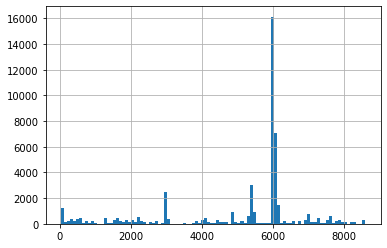

In [6]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [7]:
# analisando os produtos mais populares
df_cliente_produto['produtoid'].value_counts()

5972    15397
6085     4470
5386     3011
6082     2001
6138     1331
        ...  
6106        1
6170        1
134         1
6266        1
5909        1
Name: produtoid, Length: 900, dtype: int64

In [8]:
# o produto mais popular
df_produtos[df_produtos['dataId'] == 5972]

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
5972,5972,SANTANDER SECURITIES SERVICES BRASIL DTVM S.A.,1,None,30.353.590/0001-05,03.502.968/0001-04,None,22.5,O FUNDO tem por objetivo investir em ativos fi...,Qualquer dia,...,Fundo de Renda Fixa,Abertura,None,Aberto,Longo prazo,30.0,30.0,30.0,NaN,None


In [9]:
# vendo os clientes que compraram mais vezes o produto mais popular
df_cliente_produto[df_cliente_produto['produtoid'] == 5972]['userid'].value_counts()

1369     36
736      27
462      22
566      21
2353     20
         ..
1076      1
11321     1
3133      1
1092      1
2049      1
Name: userid, Length: 6927, dtype: int64

In [10]:
# removendo os relacionamentos duplicados (clientes que compraram o mesmo produto mais de uma vez)
df_cliente_produto = df_cliente_produto[['userid','produtoid']].drop_duplicates()

In [11]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30061 entries, 0 to 48332
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     30061 non-null  int64
 1   produtoid  30061 non-null  int64
dtypes: int64(2)
memory usage: 704.6 KB


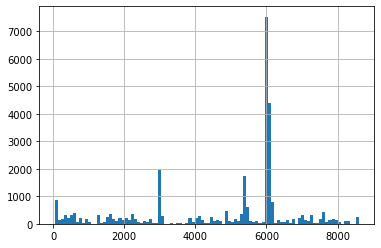

In [12]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [13]:
df_clientes.sample(2)

,userid,userid_aux,idade,genero,estadocivil,billingcity,profissaopessoa,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,...,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira,createddate,dataclienteefetivado
4792,4793,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe1r4QYV5g0r5N4Y2az...,41.7,M,M,Rio de Janeiro,Militar em Geral,0.0,0.0,0.0,...,2.0,2.0,2,6061.0,27000.0,2.0,2.0,3.0,2019-11-17 12:41:24,2019-11-17 12:00:00
7126,7127,$2b$10$.DCvvJ9WSDpqVP2xXjeSPelnWvwJ07T7SqecvlR...,67.4,F,V,São Paulo,Aposentado (Exceto Funcionário Público),0.0,0.0,0.0,...,2.0,2.0,2,5000.0,350000.0,1.0,3.0,3.0,2020-01-02 09:21:53,2020-01-02 10:26:39


In [14]:
df_clientes.describe()

,userid,idade,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,patrimoniooutros,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira
count,14188.000000,14188.000000,13780.000000,13780.000000,13780.000000,13780.000000,13628.000000,14187.000000,14188.000000,1.418800e+04,9.498000e+03,14187.000000,14187.000000,14187.000000
mean,7094.500000,36.841303,2.819303,7.294630,8.126996,0.972424,2.453625,2.467893,2.760290,7.692467e+03,8.407910e+05,2.648411,3.065130,2.100092
std,4095.867145,11.037122,11.308762,20.933896,22.452113,6.901847,1.545563,1.548641,1.083585,2.425389e+04,1.567628e+07,1.105727,1.166216,1.036411
min,1.000000,18.100000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
25%,3547.750000,28.700000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.830000e+03,3.000000e+04,2.000000,2.000000,1.000000
50%,7094.500000,35.300000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,4.000000e+03,1.900000e+05,2.000000,3.000000,2.000000
75%,10641.250000,42.800000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,9.000000e+03,6.000000e+05,3.000000,4.000000,3.000000
max,14188.000000,96.200000,100.000000,100.000000,100.000000,100.000000,5.000000,5.000000,5.000000,2.400000e+06,1.500000e+09,5.000000,5.000000,5.000000


(array([2.300e+03, 3.872e+03, 4.011e+03, 2.154e+03, 1.050e+03, 5.170e+02,
        2.110e+02, 5.700e+01, 1.300e+01, 3.000e+00]),
 array([18.1 , 25.91, 33.72, 41.53, 49.34, 57.15, 64.96, 72.77, 80.58,
        88.39, 96.2 ]),
 <a list of 10 Patch objects>)

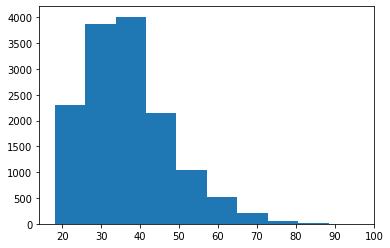

In [15]:
plt.hist(df_clientes['idade'])

In [16]:
df_clientes['idade'] = pd.cut(df_clientes['idade'], bins=[0,20,35,65,100], labels=["jovem", "jovemadulto", "adulto", "idoso"])

(array([6704.,    0.,    0., 6963.,    0.,    0.,  240.,    0.,    0.,
         281.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

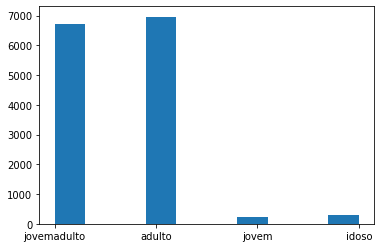

In [17]:
plt.hist(df_clientes['idade'])

In [18]:
df_produtos.sample(2)

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
1773,1773,None,0,2020-09-21,None,None,2020-09-21,20.0,"O Certificado de Depósito Bancário, de forma s...",No venc.,...,None,None,Pré fixado,None,None,NaN,NaN,NaN,5000.0,2020-09-21
6200,6200,None,0,2022-10-13,None,None,2022-10-13,15.0,"O Certificado de Depxsito Bancxrio, de forma s...",No venc.,...,None,None,Pré fixado,None,None,NaN,NaN,NaN,1000.0,2022-10-13


In [19]:
# selecionando as features do dataset de clientes a serem utilizadas
df_clientes_features = df_clientes[['userid', 'idade', 'perfilinvestidor', 'scoresituacaofinanceira', 'scorenivelconhecimento']]
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  int64   
 3   scoresituacaofinanceira  14187 non-null  float64 
 4   scorenivelconhecimento   14187 non-null  float64 
dtypes: category(1), float64(2), int64(2)
memory usage: 457.5 KB


In [20]:
df_clientes_features.loc[:, 'perfilinvestidor'] = 'perfil' + df_clientes_features['perfilinvestidor'].map(str)
df_clientes_features.loc[:, 'scoresituacaofinanceira'] = 'scoresf' + df_clientes_features['scoresituacaofinanceira'].map(str)
df_clientes_features.loc[:, 'scorenivelconhecimento'] = 'scorenc' + df_clientes_features['scorenivelconhecimento'].map(str)
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  object  
 3   scoresituacaofinanceira  14188 non-null  object  
 4   scorenivelconhecimento   14188 non-null  object  
dtypes: category(1), int64(1), object(3)
memory usage: 457.5+ KB


/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
df_clientes_features

,userid,idade,perfilinvestidor,scoresituacaofinanceira,scorenivelconhecimento
0,1,jovemadulto,perfil4,scoresf4.0,scorenc2.0
1,2,jovemadulto,perfil2,scoresf2.0,scorenc1.0
2,3,adulto,perfil1,scoresf1.0,scorenc2.0
3,4,adulto,perfil3,scoresf2.0,scorenc4.0
4,5,jovemadulto,perfil2,scoresf2.0,scorenc1.0
...,...,...,...,...,...
14183,14184,jovemadulto,perfil2,scoresf4.0,scorenc2.0
14184,14185,jovemadulto,perfil2,scoresf3.0,scorenc1.0
14185,14186,adulto,perfil2,scoresf1.0,scorenc1.0
14186,14187,jovemadulto,perfil2,scoresf2.0,scorenc3.0


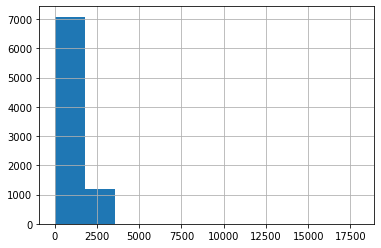

In [22]:
df_produtos['PrazoDias'].hist(bins = 10)

In [23]:
df_produtos['PrazoDias'] = pd.cut(df_produtos['PrazoDias'], bins=[0,731,1250,4000], labels=["curtoPrazo", "medioPrazo", "longoPrazo"])

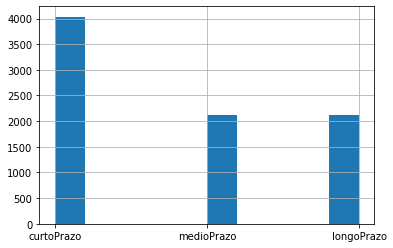

In [24]:
df_produtos['PrazoDias'].hist()

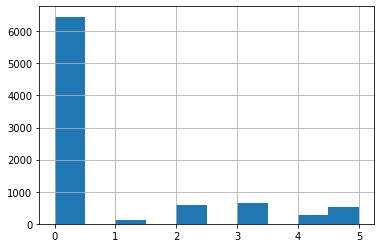

In [25]:
df_produtos['RiscoAtivo'].hist()

In [26]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 86 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   dataId                             8603 non-null   int64   
 1   AdministradorFundo                 320 non-null    object  
 2   AtivoDisponivel                    8603 non-null   int64   
 3   Carencia                           8282 non-null   object  
 4   CarteiraCNPJ                       320 non-null    object  
 5   CNPJAdministrador                  320 non-null    object  
 6   DataDeVencimento                   8282 non-null   object  
 7   DescontoIR                         8603 non-null   float64 
 8   DescricaoAtivo                     8593 non-null   object  
 9   DescricaoCarencia                  8603 non-null   object  
 10  DescricaoClasse                    8282 non-null   object  
 11  DescricaoCotizacaoAplicacao        8603 non

In [27]:
# selecionando as features do dataset de produtos a serem utilizadas
df_produtos_features = df_produtos[['dataId', 
                                    'PrazoDias', 
                                    'ResgateDias', 
                                    'RiscoAtivo', 
                                    'SeFGCAtivo', 
                                    'DescricaoTributacao',
                                    'DescricaoLiquidacaoResgate']]
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8278 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8602 non-null   float64 
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 411.9+ KB


In [28]:
df_produtos_features.loc[:,'PrazoDias'] = df_produtos_features['PrazoDias'].fillna('curtoPrazo')
df_produtos_features.loc[:,'RiscoAtivo'] = df_produtos_features['RiscoAtivo'].fillna('0')
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8603 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8603 non-null   object  
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), int64(2), object(4)
memory usage: 411.9+ KB


/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
df_produtos_features.loc[:, 'RiscoAtivo'] = 'Risco' + df_produtos_features['RiscoAtivo'].map(str)
df_produtos_features.loc[:, 'SeFGCAtivo'] = 'FGCAtivo' + df_produtos_features['SeFGCAtivo'].map(str)
df_produtos_features

,dataId,PrazoDias,ResgateDias,RiscoAtivo,SeFGCAtivo,DescricaoTributacao,DescricaoLiquidacaoResgate
0,0,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
1,1,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
2,2,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
3,3,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
4,4,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
...,...,...,...,...,...,...,...
8598,8598,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8599,8599,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8600,8600,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8601,8601,longoPrazo,No venc.,Risco5.0,FGCAtivo1,15%,No dia


In [30]:
dataset = Dataset(user_identity_features=False, 
                  item_identity_features=False)
dataset.fit((x for x in df_clientes['userid'].unique()),
            (x for x in df_produtos['dataId'].unique()), 
            user_features=df_clientes_features.drop('userid', axis=1).values.ravel(),
            item_features=df_produtos_features.drop('dataId', axis=1).values.ravel())

In [31]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 14188, num_items 8603.


In [32]:
# Construindo a matriz de interações
(interactions, weights) = dataset.build_interactions(((x[0], x[1]) for x in df_cliente_produto.values))

print(repr(interactions))

<14188x8603 sparse matrix of type '<class 'numpy.int32'>'
	with 30061 stored elements in COOrdinate format>


In [33]:
user_features = dataset.build_user_features(((x[0], [x[1], x[2], x[3], x[4]])
                                              for x in df_clientes_features.values))
print(repr(user_features))

<14188x21 sparse matrix of type '<class 'numpy.float32'>'
	with 56752 stored elements in Compressed Sparse Row format>


In [34]:
item_features = dataset.build_item_features(((x[0], [x[1], x[2], x[3], x[4], x[5], x[6]])
                                              for x in df_produtos_features.values))
print(repr(item_features))

<8603x23 sparse matrix of type '<class 'numpy.float32'>'
	with 51618 stored elements in Compressed Sparse Row format>


In [35]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [36]:
user_feature_map

{'jovemadulto': 0,
 'perfil4': 1,
 'scoresf4.0': 2,
 'scorenc2.0': 3,
 'perfil2': 4,
 'scoresf2.0': 5,
 'scorenc1.0': 6,
 'adulto': 7,
 'perfil1': 8,
 'scoresf1.0': 9,
 'perfil3': 10,
 'scorenc4.0': 11,
 'scoresf3.0': 12,
 'scorenc5.0': 13,
 'scorenc3.0': 14,
 'perfil5': 15,
 'jovem': 16,
 'idoso': 17,
 'scoresf5.0': 18,
 'scoresfnan': 19,
 'scorencnan': 20}

In [37]:
item_feature_map

{'curtoPrazo': 0,
 'No venc.': 1,
 'Risco0.0': 2,
 'FGCAtivo1': 3,
 '15%': 4,
 'No dia': 5,
 'medioPrazo': 6,
 'longoPrazo': 7,
 'Risco3.0': 8,
 'Qualquer dia': 9,
 'Risco5.0': 10,
 'FGCAtivo0': 11,
 '2 Dias úteis': 12,
 'Risco2.0': 13,
 'Risco4.0': 14,
 'Risco1.0': 15,
 'Come Cotas': 16,
 '1 Dia útil': 17,
 '5 Dias úteis': 18,
 '3 Dias úteis': 19,
 'Com carência': 20,
 'Risco0': 21,
 '4 Dias úteis': 22}

In [38]:
# dividindo o dataset em treino e teste

interactions_train, interactions_test = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=np.random.RandomState(2020)
)

In [39]:
# treinando o modelo
model = LightFM(
    no_components=10,
    learning_rate=0.05,
    loss='warp',
    random_state=2019)

model = model.fit(interactions_train,
                  user_features=user_features,
                  epochs=1000,
                  num_threads=16, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
Epoch 930
Epoch 931


In [40]:
auc_score(model, 
          interactions_train, 
          user_features=user_features, 
          num_threads=4).mean()

0.9974896

In [41]:
auc_score(model, 
          interactions_test, 
          user_features=user_features, 
          train_interactions=interactions_train, 
          num_threads=4).mean()

0.98916584

In [42]:
print(num_items)

8603


In [43]:
def sample_recommendation_new_user(model, interactions, user_feature_map, new_user_features, 
                                   item_dict, nrec_items = 5):
    
    target_indices = []
    for feature in new_user_features:
        target_indices.append(user_feature_map[feature])

    features = np.zeros(len(user_feature_map.keys()))
    for i in target_indices:
        features[i] = 1
    features = sps.csr_matrix(features)

    n_users, n_items = interactions.shape
    scores = pd.Series(model.predict(0, np.arange(num_items), 
                                     user_features=features, item_features=item_features))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Novo Usuario")
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [44]:
new_user_feature_list = ['idoso', 'perfil5', 'scoresf5.0', 'scorenc5.0' ] 

sample_recommendation_new_user(model, interactions, user_feature_map, new_user_feature_list, item_id_map)

Novo Usuario

Produtos Recomendados:
1- 8254
2- 8544
3- 910
4- 1008
5- 7894


In [45]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, nrec_items = 5):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))#, item_features=books_metadata_csr))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    user_items = list(df_cliente_produto[df_cliente_produto['userid'] == user_id]['produtoid'].values)
    user_items_indexes = list(pd.Series(user_items).apply(lambda x: item_id_map[x]))

    scores = [x for x in scores if x not in user_items_indexes]
    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Usuario: " + str(user_id))
    print("Produtos já adquiridos:")
    counter = 1
    for i in user_items:
        print(str(counter) + '- ' + str(i))
        counter+=1
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [46]:
sample_recommendation_user(model, interactions, 5, user_id_map, item_id_map)

Usuario: 5
Produtos já adquiridos:
1- 6085
2- 6082

Produtos Recomendados:
1- 8482
2- 465
3- 6782
4- 5777
5- 7121


In [48]:
# Save Evething needed by api
import pickle
pickle.dump(model, open('modelos/lightfm', 'wb'))
pickle.dump(interactions, open('modelos/interactions', 'wb'))
pickle.dump(user_feature_map, open('modelos/user_feature_map', 'wb'))
pickle.dump(item_id_map, open('modelos/item_id_map', 'wb'))
pickle.dump(item_features, open('modelos/item_features', 'wb'))



PermissionError: [Errno 13] Permission denied: 'modelos/lightfm'

In [50]:
# importing pandas as pd 
import pandas as pd 
  
# Create the dataframe 
df = pd.DataFrame({'Date':['10/2/2011', '11/2/2011', '12/2/2011', '13/2/11'], 
                    'Event':['Music', 'Poetry', 'Theatre', 'Comedy'], 
                    'Cost':[10000, 5000, 15000, 2000]}) 
  
# Print the dataframe 
print(df) 

        Date    Event   Cost
0  10/2/2011    Music  10000
1  11/2/2011   Poetry   5000
2  12/2/2011  Theatre  15000
3    13/2/11   Comedy   2000


In [57]:
for index, rows in df.iterrows():
    print([rows.Date, rows.Event, rows.Cost])


['10/2/2011', 'Music', 10000]
